In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Transformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [115]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

In [116]:
#xy좌표를 위경도로 변환
transformer = Transformer.from_crs(2097, 4326)

def convert_coordinates(lon, lat):
    new_lat, new_lon = transformer.transform(lat, lon) 
    return new_lon, new_lat

# 데이터 준비

숙소

In [117]:
#숙소
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4800000,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    accomm.dropna(axis=0,inplace=True)
    return accomm

pension=accomm_preprocess(pension)
camping=accomm_preprocess(camping)
hanok=accomm_preprocess(hanok)
resort=accomm_preprocess(resort)

In [118]:
pension['경도'], pension['위도'] = zip(*pension.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
camping['경도'], camping['위도'] = zip(*camping.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
hanok['경도'], hanok['위도'] = zip(*hanok.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
resort['경도'], resort['위도'] = zip(*resort.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [119]:
accomm_df=pd.concat([pension,camping,hanok,resort],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)

In [120]:
acco_n=list(accomm_df['개방자치단체코드'].value_counts()) #지역별 숙소 개수

부대시설(카페)

In [121]:
#카페
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    cafe=cafe.loc[:,['소재지전체주소','좌표정보(X)','좌표정보(Y)']]
    cafe.dropna(axis=0,inplace=True)
    return cafe

cafe=cafe_preprocess(cafe)
cafe['경도'], cafe['위도'] = zip(*cafe.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [122]:
cafe_address=cafe['소재지전체주소']
cafe_address_fr=cafe_address.str.slice(start=4, stop=9, step=1)
cafe['지역']=cafe_address_fr

#지역별 카페 개수
cafe_n=list(cafe_address_fr.value_counts())

비대면지수, 방문수

In [123]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['외지인방문자_평균']=(alien[1]+alien[3])/2


resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['현지인방문자_평균']=(resider[1]+resider[3])/2

attract_index=alien.index
ref_score=(alien['외지인방문자_평균']/resider['현지인방문자_평균'])*100 #선행연구 

attract_df=pd.concat([alien[0],alien['외지인방문자_평균'],
                      resider['현지인방문자_평균'],
                      ref_score],axis=1)

attract_col=['지역','외지인','현지인','비대면지수']

attract_df.columns=attract_col

In [124]:
#1차 데이터 프레임 생성
attract_df['숙소개수']=acco_n
attract_df['카페개수']=cafe_n

콘텐츠

In [125]:
contents2.drop('광역시/도',axis=1,inplace=True)

In [126]:
count_num=0
sites=[]
cities=[]
rnum=[]


for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            cities.append(contents2['시/군/구'][i])
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

#451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
#사람들이 반복해서 찾는 곳

In [127]:
popular_sites={'city':cities,'name':sites,'count':rnum,}
popular_sites=pd.DataFrame(popular_sites)

popular_sites['city'].value_counts()

city
여수시    70
목포시    39
순천시    37
나주시    23
담양군    21
광양시    21
해남군    19
영광군    19
무안군    19
화순군    18
구례군    17
완도군    17
강진군    17
보성군    16
장성군    15
고흥군    15
진도군    13
신안군    12
장흥군    11
함평군    11
영암군    11
곡성군    10
Name: count, dtype: int64

Text(0.5, 1.0, '전라남도 관광지 검색량')

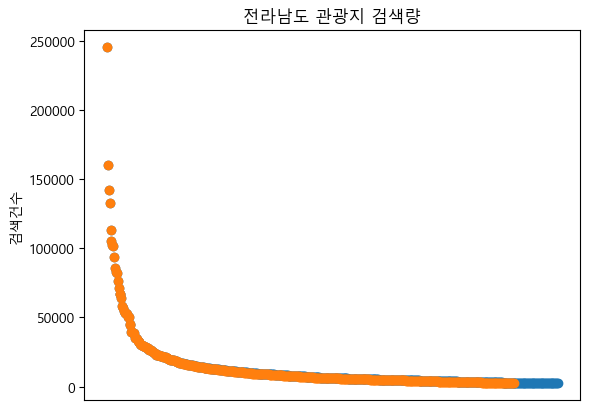

In [128]:
x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum)

plt.xticks([])

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [129]:
contents_agg=contents2.iloc[0:452]
contents_agg.drop(['순위','도로명주소'],axis=1)

,시/군/구,관광지명,중분류 카테고리,소분류 카테고리,검색건수
0,순천시,순천만국가정원,기타관광,기타관광,245254
1,목포시,목포역,기타관광,교통시설,159899
2,순천시,순천역,기타관광,교통시설,141882
3,담양군,죽녹원,자연관광,자연공원,132973
4,여수시,오동도,자연관광,자연경관(하천/해양),113284
...,...,...,...,...,...
447,순천시,순천만달밤야시장,쇼핑,시장,2933
448,고흥군,능가사,역사관광,종교성지,2933
449,목포시,목포해양경찰서전용부두,자연관광,자연경관(하천/해양),2918
450,강진군,마량놀토수산시장,쇼핑,시장,2895


In [130]:
# 고흥군 없음(15곳)
# 장흥군 없음(11곳)

In [131]:
# def sites_preprocess(s):
#     s=s[['관광지명','위도','경도']]
#     return s

# naju=sites_preprocess(naju)
# haenam=sites_preprocess(haenam)
# younggwang=sites_preprocess(younggwang)
# hwasun=sites_preprocess(hwasun)
# gurye=sites_preprocess(gurye)
# wando=sites_preprocess(wando)
# gangjin=sites_preprocess(gangjin)
# boseong=sites_preprocess(boseong)
# jangseong=sites_preprocess(jangseong)

# jindo=sites_preprocess(jindo)
# sinan=sites_preprocess(sinan)

# hampyeong=sites_preprocess(hampyeong)
# yeongam=sites_preprocess(yeongam)
# gokseong=sites_preprocess(gokseong)

In [132]:
def city_counter(cityname):
    city=contents_agg.loc[contents_agg['시/군/구']==cityname]
    city_num=len(city)
    print(city_num)
    return city #작업잘됨

def city_coord_preprocess(city):
    city_lat=[0]*len(city)
    city_long=[0]*len(city)
    return city_lat,city_long

def city_coord_collect(cityname):
    cityname_lat=cityname['위도']
    cityname_long=cityname['경도']
    return cityname_lat,cityname_long

def city_coord_agg(city,cityname,city_lat,city_long,cityname_lat,cityname_long):
    tour_spot=city['관광지명']
    tour_attr=cityname['관광지명']
    for i in range(len(city)):
        for j in range(len(cityname)):
            if tour_spot.iloc[i]==tour_attr.iloc[j]:
             city_lat[i]=cityname_lat.iloc[j]
             city_long[i]=cityname_long.iloc[j]
    city['위도']=city_lat
    city['경도']=city_long
    return city

In [133]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위',
                      '관광지명','도로명주소'], axis=1).reset_index(drop=True)

In [134]:
visit=[]
contents_keyword=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])
            contents_keyword.append(contents_df['소분류 카테고리'][j])

meal['검색건수']=visit
meal['지역_키워드']=contents_keyword

In [135]:
meal_columns=['항목','음식점개수','경도','위도','검색건수','지역키워드']
meal.columns=meal_columns

In [136]:
meal['관광지']=[76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12]

In [137]:
a_index=attract_df['지역']
m_index=meal['항목']

calmness=[]
accommodation=[]
cafeteria=[]

entranger_avg=[]
aborigene_avg=[]



for i in range(len(meal)):
    for j in range(len(attract_df)):
        if m_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
            cafeteria.append(attract_df['카페개수'][j])
            aborigene_avg.append(attract_df['현지인'][j])
            entranger_avg.append(attract_df['외지인'][j])
        else:
            continue


meal['비대면지수']=calmness
meal['숙소개수']=accommodation
meal['카페개수']=cafeteria

meal['현지인_평균']=aborigene_avg

meal['외지인_평균']=entranger_avg

meal['음식점개수']=meal['음식점개수'].astype('int64')

# 특성 스케일링(표준화)

: 항목 마다 값이 크게 다르니 이상치에 영향 덜 받는 표준화로 특성 스케일링

In [138]:
ck=pd.get_dummies(contents_keyword,dtype='int64') #지역별 키워드를 원핫 인코딩

feat_df=pd.concat([meal,ck],axis=1,ignore_index=True)

#특성 스케일링용 데이터 프레임
feat_df.drop([2,3,5],axis=1,inplace=True) #경도, 위도,지역키워드, 최종점수 제거
feat_df=feat_df.set_index([0])

feat_df.columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인','외지인',
                  '교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지']

print(feat_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   음식점개수        22 non-null     int64  
 1   검색건수         22 non-null     int64  
 2   관광지          22 non-null     int64  
 3   비대면지수        22 non-null     float64
 4   숙소개수         22 non-null     int64  
 5   카페개수         22 non-null     int64  
 6   현지인          22 non-null     float64
 7   외지인          22 non-null     float64
 8   교통시설         22 non-null     int64  
 9   기타관광         22 non-null     int64  
 10  쇼핑몰          22 non-null     int64  
 11  시장           22 non-null     int64  
 12  육상레저스포츠      22 non-null     int64  
 13  자연경관(하천/해양)  22 non-null     int64  
 14  자연공원         22 non-null     int64  
 15  종교성지         22 non-null     int64  
dtypes: float64(3), int64(13)
memory usage: 2.9+ KB
None


In [139]:
scaler=StandardScaler()

f_df=pd.DataFrame((scaler.fit_transform(feat_df)),
                  columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인',
                  '외지인','교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지'])

In [140]:
#실제 평가된 지역의 워케이션 점수 추가
prof_score=[5,4,3,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,2,0,0,0]
f_df['최종점수']=prof_score

<Axes: >

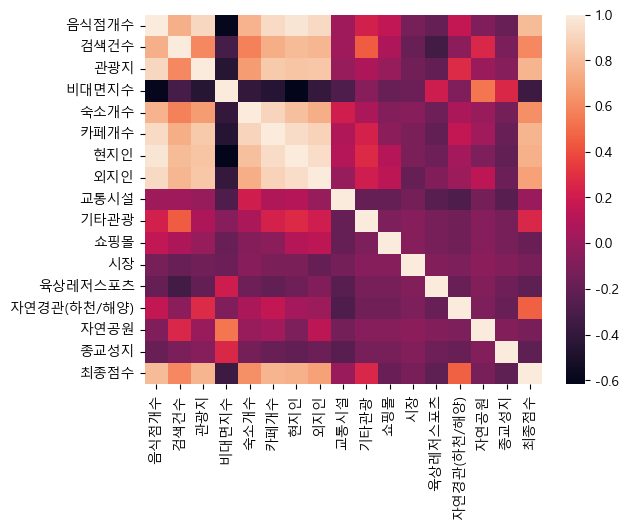

In [141]:
#선행연구에서 제시한 '비대면지수'가 이질적으로 다른 요인과 대조됨.
#새로운 평가지표 개발 필요

f_corr=f_df.corr()
sns.heatmap(f_corr,cbar=True)

In [142]:
f_corr['최종점수'].sort_values(ascending=False)

최종점수           1.000000
음식점개수          0.794086
카페개수           0.772480
관광지            0.771025
현지인            0.756162
외지인            0.695387
숙소개수           0.622158
검색건수           0.596756
자연경관(하천/해양)    0.460455
기타관광           0.254951
교통시설           0.006330
시장            -0.121800
자연공원          -0.121800
쇼핑몰           -0.176505
종교성지          -0.221789
육상레저스포츠       -0.221789
비대면지수         -0.362366
Name: 최종점수, dtype: float64

# 새 평가지표 개발

In [143]:
lr_df=f_df.sort_values(by=['최종점수'],ascending=False).copy()

scored_x=lr_df.iloc[[0,1,2,3,4,5],:-1] #점수 공표된 지역들
tobe_x=lr_df.iloc[6:,:-1]

scored_y=lr_df.iloc[[0,1,2,3,4,5],-1:] #지역별 점수

scored_f=lr_df.iloc[[0,1,2,3,4,5],:]

Text(0, 0.5, '실제 점수')

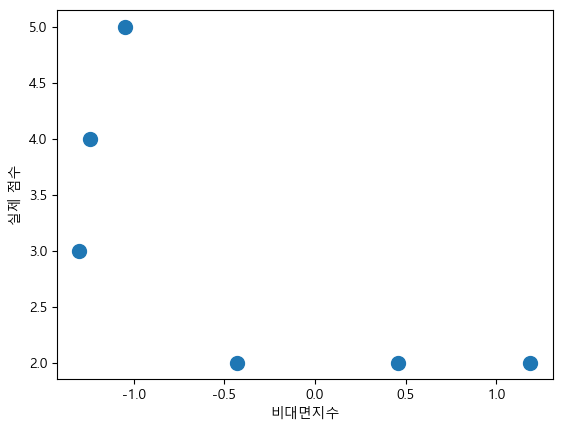

In [144]:
plt.scatter(scored_x['비대면지수'],scored_y,s=100)

plt.xlabel('비대면지수')
plt.ylabel('실제 점수')

#비대면지수가 낮을수록 높은 점수를 받음
#즉 워케이션에 비대면지수를 높게 부여한 선행연구 결과와 (또) 대조

In [145]:
poly_features=PolynomialFeatures(degree=3,include_bias=False)

x_poly=poly_features.fit_transform(scored_x)

In [146]:
lr=LinearRegression()

lr.fit(scored_x,scored_y)
predict_y=lr.predict(tobe_x)

lr_df.iloc[6:,-1:]=predict_y

print(lr_df)

       음식점개수      검색건수       관광지     비대면지수      숙소개수      카페개수       현지인  \
0   2.850863  0.836628  3.818339 -1.048810  1.755801  2.580347  2.122529   
1   2.132107  3.231442  1.309703 -1.242790  0.461714  1.623724  2.438057   
2   1.951917  1.682534  1.238028 -1.298716  3.971704  2.721291  2.508266   
13 -0.533698 -0.495772 -0.482179  0.456271 -0.300557 -0.376488 -0.603661   
18 -0.642813 -0.798205 -0.625530  1.187936 -0.655102 -0.772332 -0.692423   
8  -0.338493 -0.161874 -0.482179 -0.431506 -0.282830 -0.175567 -0.456008   
20 -0.713888 -0.397726 -0.840556  0.841082 -0.087830 -0.163572 -0.722775   
19 -0.651822 -0.589554 -0.482179  0.200875 -0.619647 -0.706358 -0.698742   
17 -0.608777  0.078424 -0.338829  1.045558 -0.123285 -0.172568 -0.726932   
16 -0.593761 -0.845168 -0.410504 -0.412144 -0.318284 -0.517432 -0.554437   
15 -0.583751 -0.845077 -0.697205 -0.784363 -0.300557 -0.493442 -0.494835   
14 -0.551717 -0.231376 -0.338829  1.255901 -0.548738 -0.667373 -0.540414   
11 -0.441601

In [147]:
corr_score=lr_df.corrwith(lr_df['최종점수'])
print(corr_score.sort_values(ascending=False))

최종점수           1.000000
관광지            0.963642
음식점개수          0.937748
외지인            0.900227
현지인            0.868873
카페개수           0.838894
검색건수           0.679513
숙소개수           0.591084
기타관광           0.229041
자연경관(하천/해양)    0.199468
쇼핑몰            0.089276
자연공원           0.012926
종교성지          -0.104464
교통시설          -0.106164
육상레저스포츠       -0.151000
시장            -0.173722
비대면지수         -0.434757
dtype: float64


# 주성분 분석
데이터의 개수가 매우 적다(22개)는 점 고려해 데이터셋을 대표하는 주성분 추출

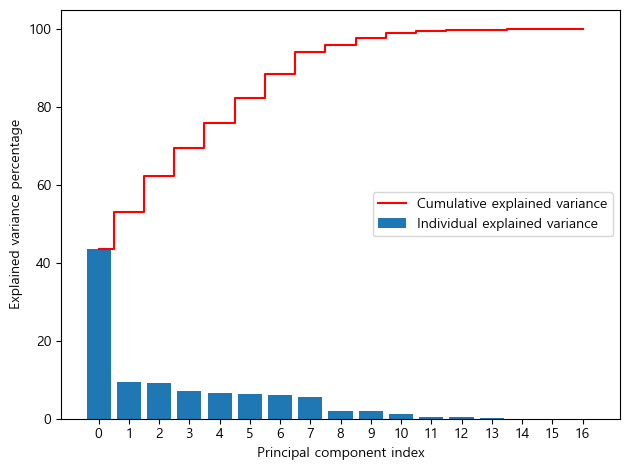

In [148]:
pca = PCA(n_components=None)
pca.fit(f_df)

exp_var = pca.explained_variance_ratio_ * 100 #해당 주성분으로 설명되는 분산 비율
cum_exp_var = np.cumsum(exp_var) #누적 (설명가능) 비율

plt.bar(range(0,17), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(0,17), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(0,17)))
plt.legend(loc=5)
plt.tight_layout()

In [149]:
#(누적)설명 정도가 약 90%에 이르는 7개 선택
pca=PCA(n_components=7)
x_pca=pca.fit_transform(f_df)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

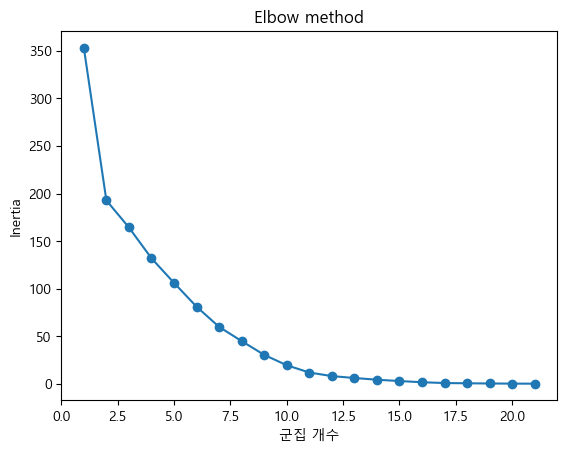

In [150]:
inertias = []

for i in range(1,22):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,22), inertias, marker='o')

plt.title('Elbow method')
plt.xlabel('군집 개수')
plt.ylabel('Inertia')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


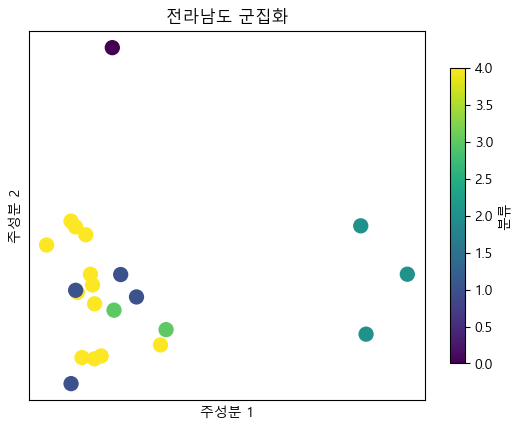

In [151]:
kmeans = KMeans(n_clusters=5,random_state=42)
kmeans.fit(x_pca)

x22=np.arange(len(f_df))
plt.scatter(x_pca[:,0],x_pca[:,1],c=kmeans.labels_,s=100)

plt.xticks([])
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.yticks([])
plt.colorbar(shrink=0.8,label='분류')

plt.title('전라남도 군집화')
plt.show()

유형1: 순천시, 여수시, 목포시

유형2: 광양시, 무안군

유형3: 담양군

유형4: 장흥 보성 고흥 진도

유형5:그외

In [152]:
ys=pd.read_excel('./ys.xlsx')
sc=pd.read_excel('./sc.xlsx')
mp=pd.read_excel('./mp.xlsx')

mn=pd.read_excel('./mn.xlsx')
gy=pd.read_excel('./gy.xlsx')

dy=pd.read_excel('./dy.xlsx')

hn=pd.read_excel('./hn.xlsx')
nj=pd.read_excel('./nj.xlsx')
gr=pd.read_excel('./gr.xlsx')
wd=pd.read_excel('./wd.xlsx')
gj=pd.read_excel('./gj.xlsx')
bs=pd.read_excel('./bs.xlsx')
js=pd.read_excel('./js.xlsx')
jd=pd.read_excel('./jd.xlsx')
sn=pd.read_excel('./sn.xlsx')
hp=pd.read_excel('./hp.xlsx')
ym=pd.read_excel('./ym.xlsx')
gs=pd.read_excel('./gs.xlsx')

In [153]:
type_1=pd.concat([ys,sc,mp],ignore_index=True).drop(['도로명주소'],axis=1)
type_2=pd.concat([mn,gy],ignore_index=True).drop(['도로명주소'],axis=1)
type_4=pd.concat([bs,jd],ignore_index=True).drop(['도로명주소'],axis=1)
dy.drop(['도로명주소'],axis=1)

t1_f1=type_1['중분류 카테고리'].value_counts().to_frame()

t2_f1=type_2['중분류 카테고리'].value_counts().to_frame()

dy_f1=dy['중분류 카테고리'].value_counts().to_frame()

t4_f1=type_4['중분류 카테고리'].value_counts().to_frame()

In [154]:
type=('유형1','유형2','유형3','유형4')
type_dict={"feat":(t1_f1,t2_f1,dy_f1,t4_f1),
           'count':(t1_f1['count'],t2_f1['count'],dy_f1['count'],t4_f1['count'])}

Text(0.5, 1.0, '전라남도 군집별 특징')

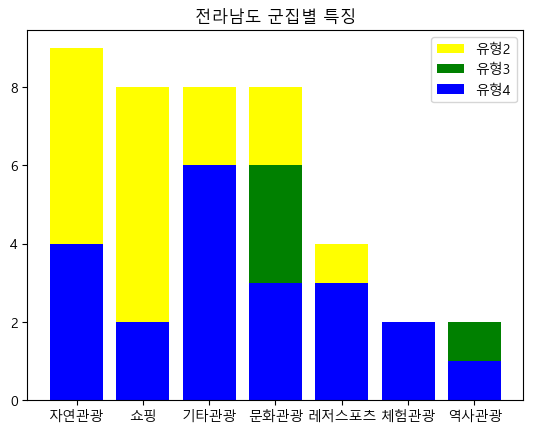

In [155]:
#plt.bar(t1_f1.index,t1_f1['count'],color='purple',label='유형1')
plt.bar(t2_f1.index,t2_f1['count'],color='yellow',label='유형2')
plt.bar(dy_f1.index,dy_f1['count'],color='g',label='유형3')
plt.bar(t4_f1.index,dy_f1['count'],color='b',label='유형4')

plt.legend()

plt.title('전라남도 군집별 특징')

#보라색: 기존 인기 휴양지. 
#노란색: 자연 '관광'
#초록색: 자연+ '활동'
#유형4: 컨트리클럽 다수 포진, 그 외 관광 요소 많이 보유
#담양: 문화, 역사

# 시각화

In [156]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

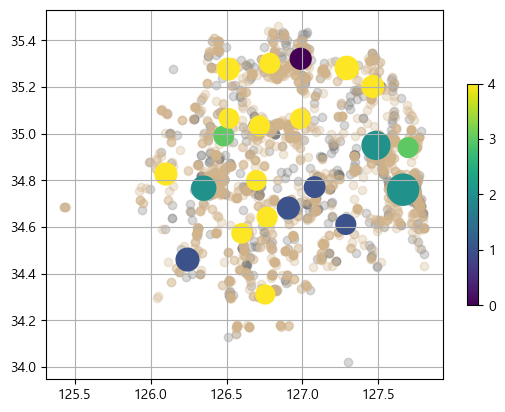

In [176]:
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.3,c='grey')
plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.3,c='tan')

plt.scatter(meal['경도'],meal['위도'],
            c=kmeans.labels_,s=lr_df['최종점수']*100)

plt.scatter(type_1['경도'],type_1['위도'])
plt.scatter(type_2['경도'],type_2['위도'])
plt.scatter(dy['경도'],dy['위도'])
plt.scatter(type_4['경도'],type_4['위도'])


plt.colorbar(shrink=0.6).set_ticks([0,1,2,3,4])

plt.grid()
plt.show()

# MCLP

관광지              0.963642
음식점개수          0.937748
외지인            0.900227
현지인            0.868873
카페개수           0.838894
검색건수           0.679513
숙소개수           0.591084

In [158]:
minmax=MinMaxScaler()

In [159]:
t1_visit=type_1[['검색건수']]
t2_visit=type_2[['검색건수']]
t3_visit=dy[['검색건수']]
t4_visit=type_4[['검색건수']]

t_visit=pd.concat([t1_visit,t2_visit,t3_visit,t4_visit],ignore_index=True)
t_visit=minmax.fit_transform(t_visit)
t_visit

array([[4.55486192e-01],
       [4.21755796e-01],
       [3.75944348e-01],
       [3.31131402e-01],
       [3.26679402e-01],
       [2.63088838e-01],
       [2.08431155e-01],
       [1.71317404e-01],
       [1.46899485e-01],
       [1.19977059e-01],
       [1.15042313e-01],
       [1.04062914e-01],
       [8.91513969e-02],
       [8.82189113e-02],
       [8.15553529e-02],
       [7.54323061e-02],
       [7.18674055e-02],
       [6.45478064e-02],
       [5.89528930e-02],
       [5.42739610e-02],
       [4.64303545e-02],
       [4.25642528e-02],
       [3.90612428e-02],
       [3.68991967e-02],
       [3.35158419e-02],
       [3.23357938e-02],
       [3.15724760e-02],
       [2.89771954e-02],
       [2.67615106e-02],
       [2.48429009e-02],
       [2.35349455e-02],
       [2.31801059e-02],
       [2.30687027e-02],
       [1.93511386e-02],
       [1.88848958e-02],
       [1.88683916e-02],
       [1.84392832e-02],
       [1.68301267e-02],
       [1.66238246e-02],
       [1.53406254e-02],


In [160]:
#음식점 개수
t1_meal=meal.loc[:,['항목','음식점개수','경도','위도']].iloc[[0,1,2]]
t2_meal=meal.loc[:,['항목','음식점개수','경도','위도']].iloc[[3,5]]
t3_meal=meal.loc[:,['항목','음식점개수','경도','위도']].iloc[[11]]
t4_meal=meal.loc[:,['항목','음식점개수','경도','위도']].iloc[[8,13,15,19]]

t_meal=pd.concat([t1_meal,t2_meal,t3_meal,t4_meal],ignore_index=True)
t_meal_num=t_meal[['음식점개수']]

t_m_num=minmax.fit_transform(t_meal_num) #지역 반지름

#카페 개수
t1_cafe=meal.loc[:,['항목','카페개수','경도','위도']].iloc[[0,1,2]]
t2_cafe=meal.loc[:,['항목','카페개수','경도','위도']].iloc[[3,5]]
t3_cafe=meal.loc[:,['항목','카페개수','경도','위도']].iloc[[11]]
t4_cafe=meal.loc[:,['항목','카페개수','경도','위도']].iloc[[8,13,15,19]]

t_cafe=pd.concat([t1_cafe,t2_cafe,t3_cafe,t4_cafe],ignore_index=True)
t_cafe_num=t_cafe[['카페개수']]

t_c_num=minmax.fit_transform(t_cafe_num) #카페 반지름


In [161]:
accomm_code=accomm_df['개방자치단체코드']

ys_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4810000]
sc_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4820000]
mp_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4800000]
t1_accomm=pd.concat([ys_accomm,sc_accomm,mp_accomm],ignore_index=True) #450개

gy_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4840000]
mn_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4950000]
t2_accomm=pd.concat([gy_accomm,mn_accomm],ignore_index=True) #36개

t3_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4850000] #27개

jh_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4910000]
bs_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4890000]
gh_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==4880000]
jd_accomm=accomm_df.loc[accomm_df['개방자치단체코드']==5000000]
t4_accomm=pd.concat([jh_accomm,bs_accomm,
                     gh_accomm,jd_accomm],ignore_index=True) #120개

In [162]:
cafe['지역']=cafe_address_fr
cafe_fr=cafe.loc[:,['경도','위도','지역']]
cafe_fr=cafe_fr.set_index('지역')

In [163]:
ys_cafe=cafe_fr.loc[' 여수시 ']
sc_cafe=cafe_fr.loc[' 순천시 ']
mp_cafe=cafe_fr.loc[' 목포시 ']

gy_cafe=cafe_fr.loc[' 광양시 ']
mn_cafe=cafe_fr.loc[' 무안군 ']

dy_cafe=cafe_fr.loc[' 담양군 ']

jh_cafe=cafe_fr.loc[' 장흥군 ']
bs_cafe=cafe_fr.loc[' 보성군 ']
gh_cafe=cafe_fr.loc[' 고흥군 ']
jd_cafe=cafe_fr.loc[' 진도군 ']

In [164]:
t1_cafe=pd.concat([ys_cafe,sc_cafe,mp_cafe],ignore_index=True)
t2_cafe=pd.concat([gy_cafe,mn_cafe],ignore_index=True)
t4_cafe=pd.concat([jh_cafe,bs_cafe,
                   gh_cafe,jd_cafe],ignore_index=True)

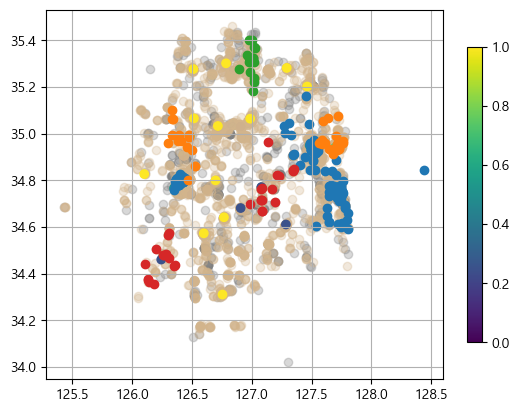

In [170]:
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.3,c='grey')
plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.3,c='tan')

plt.scatter(meal['경도'],meal['위도'],c=kmeans.labels_)

plt.scatter(type_1['경도'],type_1['위도'])
plt.scatter(type_2['경도'],type_2['위도'])
plt.scatter(dy['경도'],dy['위도'])
plt.scatter(type_4['경도'],type_4['위도'])

plt.colorbar(shrink=0.8)

plt.grid()
plt.show()